In [1]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

### Find all metabolites that are significant under sampling:OGTT term and divide into 3 groups:
#### Considering dropping features where one of the slopes is very close to 0
##### Possible grouping #1: 
1.	Fasted nearly 0 slope, fed non-zero slope
2.	Fasted non-zero slope, fed nearly 0 slope
3.	Fasted and fed different slopes, both non-zero

##### Another possible grouping #2:
1.	|Fasted slope| > |fed slope|
2.	|Fed slope| > |fasted slope|

##### Another grouping #3:
1.	Both slopes positively correlate with OGTT
2.	Both slopes negatively correlate with OGTT
3.	Fasted is positive and fed is negative
4.	Fed is positive and fasted is negative 


#### Find enrichment of lipid class in each grouping (I think TGs will be enriched in one more than the other. Same for PCs) 


## Fasted and fed slopes and intercepts are calculated from the model parameters 

In [17]:
min_ogtt, max_ogtt = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].min(), ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].max()

def get_model_fits(params): 
    # Note: RBG is first, FBG is second in tuple
    intercept = params['model_param_Intercept']
    sampling_RBG = params['model_param_sampling[T.RBG]']
    ogtt_param = params['model_param_ogtt']
    cross = params['model_param_sampling[T.RBG]:ogtt']
    interceptfbg = intercept
    interceptrbg = interceptfbg + sampling_RBG
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + cross * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + cross * max_ogtt
     
    return {'rbg_slope': ((maxrbg-minrbg)/(max_ogtt-min_ogtt)), 'fbg_slope': ((maxfbg-minfbg)/(max_ogtt-min_ogtt)),
            'rbg_line': [[min_ogtt, max_ogtt], [minrbg, maxrbg]], 'fbg_line': [[min_ogtt, max_ogtt], [minfbg, maxfbg]],
            'rbg_min': minrbg, 'rbg_max': maxrbg, 'fbg_min': minfbg, 'fbg_max': maxfbg}

def get_model_params(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  

## Using slopes of each of the fitted lines from the fixed effects model, find groupings of metabolites according to possible groupings listed above

In [18]:
param_cols = data.filter(regex='model_param').columns
data['fit_rbg_min'] = data.apply((lambda x: get_model_fits(x)['rbg_min']), axis=1)
data['fit_rbg_max'] = data.apply((lambda x: get_model_fits(x)['rbg_max']), axis=1)
data['fit_fbg_min'] = data.apply((lambda x: get_model_fits(x)['fbg_min']), axis=1)
data['fit_fbg_max'] = data.apply((lambda x: get_model_fits(x)['fbg_max']), axis=1)

data['fit_rbg_slope'] = data.apply((lambda x: get_model_fits(x)['rbg_slope']), axis=1)
data['fit_fbg_slope'] = data.apply((lambda x: get_model_fits(x)['fbg_slope']), axis=1)
data['fit_rbg_line'] = data.apply((lambda x: get_model_fits(x)['rbg_line']), axis=1)
data['fit_fbg_line'] = data.apply((lambda x: get_model_fits(x)['fbg_line']), axis=1)
data['fit_rbg_slope']

i
m_0      0.000093
m_1      0.000037
m_2     -0.000010
m_3     -0.000004
m_4     -0.000032
           ...   
l_868    0.000051
l_869    0.000054
l_870    0.000038
l_871    0.000045
l_872    0.000048
Name: fit_rbg_slope, Length: 1371, dtype: float64

# Plotting metabolites with scatterplot dots averaged within sampling and animal

In [19]:
fit_cols = data.filter(regex='fit_')

mean_within_animal_sampling = data[data_cols] \
    .T \
    .join(fg[['animal', 'bg_type']]) \
    .groupby(['animal', 'bg_type']).mean() \
    .reset_index().set_index('animal') \
    .join(ap['OGTT (AUC)']) 

mean_within_animal_sampling  # .join(fit_cols)

,bg_type,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_9,...,l_864,l_865,l_866,l_867,l_868,l_869,l_870,l_871,l_872,OGTT (AUC)
animal,,,,,,,,,,,,,,,,,,,,,
1060,FBG,19.384185,20.342467,23.747611,24.675900,21.175787,22.884704,22.365933,21.535287,22.421491,...,18.478126,17.734779,19.078503,19.190682,20.803520,19.296442,20.252629,20.387191,19.783565,48742.5
1060,RBG,20.849207,21.740409,22.271725,24.033566,23.233432,23.258714,22.732897,23.175415,22.890434,...,19.358470,18.126462,19.756921,19.352792,20.460141,18.606328,17.798183,17.407695,15.978999,48742.5
1062,FBG,17.443496,20.618731,23.929733,24.351975,24.288569,22.828534,22.319930,21.846785,22.357512,...,18.093069,17.238210,18.090474,18.484782,19.943932,18.167369,19.559432,19.492728,18.721313,43717.5
1062,RBG,17.770239,21.970095,23.078494,23.816927,27.252883,23.597743,23.069778,23.490245,23.277979,...,20.152347,18.841987,20.492684,19.932352,20.478440,18.989725,18.421153,18.070175,15.943302,43717.5
1074,FBG,17.921037,20.978108,22.920749,24.454637,25.451442,23.159768,22.845992,22.215595,22.977996,...,19.020567,18.069863,18.910541,18.996897,19.947317,18.871539,19.316247,19.372435,18.091690,35250.0
1074,RBG,16.937191,21.808187,22.741477,23.393868,27.235312,23.240854,22.907276,23.327459,23.063404,...,19.462282,18.439556,20.100196,19.541195,20.005335,18.525453,17.773436,17.570037,15.362908,35250.0
1076,FBG,21.336339,21.123610,22.369026,23.990699,22.056913,22.776006,22.204800,21.654299,22.232570,...,18.826895,18.375756,19.701053,19.391497,20.280191,18.454885,19.730483,19.532113,19.224106,60245.0
1076,RBG,22.498499,22.296065,23.066708,23.264967,23.519169,23.254285,22.875307,23.127997,23.006478,...,22.428175,21.011519,22.704905,21.204837,22.541603,21.181057,19.912312,19.971792,17.869054,60245.0
1082,FBG,21.755225,20.930137,23.927383,24.349442,23.970608,22.851289,22.441951,21.533222,22.499360,...,16.659214,15.285513,16.651266,16.802309,19.599022,16.352400,19.173973,19.339970,18.866604,56462.5


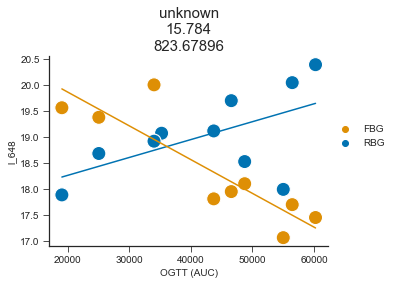

In [20]:
def plot_mean_fits(feature):
    fig, ax = plt.subplots(figsize=(5, 3.5))
    sns.scatterplot(
        data=mean_within_animal_sampling, x='OGTT (AUC)', y=feature,
        hue='bg_type', s=200, palette=colors, ax=ax)
    plt.plot(*fit_cols.loc[feature, 'fit_rbg_line'], color=colors['RBG'])
    plt.plot(*fit_cols.loc[feature, 'fit_fbg_line'], color=colors['FBG'])
    plt.legend(loc=(1.01, 0.5))
    plt.title('\n'.join(data.loc[feature, ['ID', 'RT', 'm/z']].astype('str').to_list()), fontsize=15)
    sns.despine()
feature = 'l_648'
plot_mean_fits(feature)

Text(0.5, 1.0, 'For metabolites significant under interaction term\nRandom-fed slopes are mostly positive')

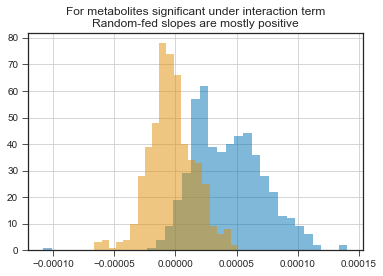

In [26]:
# Possible grouping #1:
#     Fasted nearly 0 slope, fed non-zero slope
#     Fasted non-zero slope, fed nearly 0 slope
#     Fasted and fed different slopes, both non-zero

# Make a distribution of slopes for both random-fed and fasted, for metabolites with cross q-value < 0.05
isdf = data.loc[data['qval_sampling:ogtt'] < 0.05]  # isdf = Interaction Significant DataFrame
isdf['fit_rbg_slope'].hist(bins=35, alpha=0.5, color=colors['RBG'])
# plt.figure()
isdf['fit_fbg_slope'].hist(bins=20, alpha=0.5, color=colors['FBG'])
plt.title('For metabolites significant under interaction term\nRandom-fed slopes are mostly positive')

In [29]:
# Another possible grouping #2:

#     True if |Fed slope| > |Fasted slope| else False
#     |Fed slope| > |fasted slope|

isdf['group2'] = isdf.loc[:, ['fit_rbg_slope', 'fit_fbg_slope']].apply(lambda x: abs(x[0]) > abs(x[1]), axis=1)
print('number of |fed slopes| > |fasted slopes|:', isdf['group2'].sum())

number of |fed slopes| > |fasted slopes|: 415


C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# Another grouping #3:

#     Both slopes positively correlate with OGTT
#     Both slopes negatively correlate with OGTT
#     Fasted is positive and fed is negative
#     Fed is positive and fasted is negative

def group3(row):
    rbg_slope = row[0]
    fbg_slope = row[1]
    if rbg_slope > 0 and fbg_slope > 0:
        return 'both pos'
    elif rbg_slope < 0 and fbg_slope < 0:
        return 'both neg'
    elif rbg_slope > 0 and fbg_slope < 0:
        return 'fed pos, fasted neg'
    elif rbg_slope < 0 and fbg_slope > 0:
        return 'fed neg, fasted pos'
    
isdf['group3'] = isdf[['fit_rbg_slope', 'fit_fbg_slope']].apply(lambda x: group3(x), axis=1)
isdf['group3'].value_counts()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fed pos, fasted neg    295
both pos               198
both neg                20
fed neg, fasted pos      2
Name: group3, dtype: int64

## 2 metabolites buck the trend and have Fed=negative slope, Fasted=positive slope
1. m_625 = unknown
2. l_150 = PC 38:7 

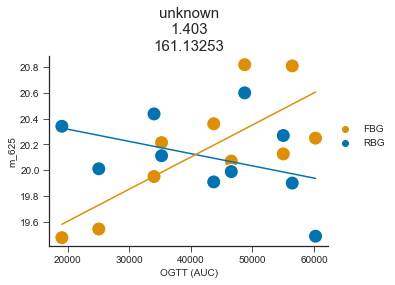

<Figure size 432x288 with 0 Axes>

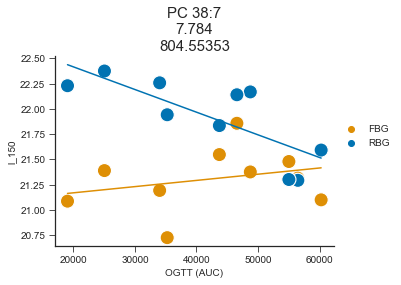

In [31]:
plot_mean_fits('m_625')
plt.figure()
plot_mean_fits('l_150')

### When both fed and fasted have negative slopes, all 20 are metabolites, none are lipids 

In [32]:
isdf.loc[isdf['group3'] == 'both neg']

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,fit_rbg_min,fit_rbg_max,fit_fbg_min,fit_fbg_max,fit_rbg_slope,fit_fbg_slope,fit_rbg_line,fit_fbg_line,group2,group3
i,,,,,,,,,,,,,,,,,,,,,
m_7,Trigonelline_9.139_138.05502,9.139,138.05502,[M+H]+1,metabolite,+,Trigonelline,23.547123,23.325673,21.397206,...,23.439491,23.140544,22.541140,21.458955,-7.258624e-06,-0.000026,"[[19060.0, 60245.0], [23.43949093146824, 23.14...","[[19060.0, 60245.0], [22.541139966280504, 21.4...",False,both neg
m_26,Pyroglutamic acid_12.646_147.07649,12.646,147.07649,[M+NH4]+1,metabolite,+,Pyroglutamic acid,26.772092,26.967102,26.878423,...,26.891816,26.880453,27.299172,26.730098,-2.758880e-07,-0.000014,"[[19060.0, 60245.0], [26.891815543955676, 26.8...","[[19060.0, 60245.0], [27.299171987351443, 26.7...",False,both neg
m_56,unknown_12.63_181.0376,12.630,181.03760,[M-H]-1,metabolite,-,unknown,19.684059,20.102916,19.484556,...,19.815779,19.745888,20.227855,19.478691,-1.697016e-06,-0.000018,"[[19060.0, 60245.0], [19.815779243105066, 19.7...","[[19060.0, 60245.0], [20.22785490450404, 19.47...",False,both neg
m_60,unknown_9.881_148.04271,9.881,148.04271,[M-H]-1,metabolite,-,unknown,20.768966,20.237077,18.838112,...,20.467013,20.451334,20.394726,19.035477,-3.806921e-07,-0.000033,"[[19060.0, 60245.0], [20.467012533301727, 20.4...","[[19060.0, 60245.0], [20.394726366427797, 19.0...",False,both neg
m_61,unknown_12.828_133.06088,12.828,133.06088,[M+NH4]+1,metabolite,+,unknown,23.025060,22.598590,21.784341,...,22.756975,22.713120,22.528477,21.717179,-1.064846e-06,-0.000020,"[[19060.0, 60245.0], [22.756975352074086, 22.7...","[[19060.0, 60245.0], [22.52847672230808, 21.71...",False,both neg
m_207,unknown_8.572_176.1394,8.572,176.13940,[M+H]+1,metabolite,+,unknown,23.086674,23.175012,22.828974,...,23.221583,22.785719,23.511558,22.616625,-1.058308e-05,-0.000022,"[[19060.0, 60245.0], [23.221583352657746, 22.7...","[[19060.0, 60245.0], [23.51155769561644, 22.61...",False,both neg
m_220,Betaine_8.574_118.08656,8.574,118.08656,[M+H]+1,metabolite,+,Betaine,27.560760,27.630282,27.304524,...,27.712101,27.270041,27.967044,27.128216,-1.073351e-05,-0.000020,"[[19060.0, 60245.0], [27.712100882831514, 27.2...","[[19060.0, 60245.0], [27.96704427171678, 27.12...",False,both neg
m_225,unknown_12.845_131.04513,12.845,131.04513,[M-H]-1,metabolite,-,unknown,24.226682,24.031969,23.093844,...,24.109834,24.045749,23.857004,23.033745,-1.556047e-06,-0.000020,"[[19060.0, 60245.0], [24.109834386339557, 24.0...","[[19060.0, 60245.0], [23.857003609044142, 23.0...",False,both neg
m_226,Asparagine_12.852_133.06101,12.852,133.06101,[M+H]+1,metabolite,+,Asparagine,23.025060,22.592129,21.781089,...,22.747098,22.701390,22.514098,21.685732,-1.109834e-06,-0.000020,"[[19060.0, 60245.0], [22.747098324787494, 22.7...","[[19060.0, 60245.0], [22.514098159363908, 21.6...",False,both neg


In [33]:
# Hard to draw a conclusion from these value counts
isdf.loc[isdf['group3'] == 'fed pos, fasted neg', 'molec_class'].value_counts()

unknown         109
TG               29
PC               15
SM                4
Plasmenyl-PE      4
Plasmanyl-PE      4
Cer[NS]           4
Plasmanyl-PC      3
PI                1
Plasmenyl-PC      1
CE                1
Name: molec_class, dtype: int64

In [245]:
# Only m_602 unknown metabolite has both positive slopes, but rbg_slope < fbg_slope
isdf.loc[(isdf['fit_rbg_slope'] < isdf['fit_fbg_slope'])\
         & (isdf['fit_rbg_slope'] > 0)
        ]

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,fit_rbg_min,fit_rbg_max,fit_fbg_min,fit_fbg_max,fit_fbg_slope,fit_rbg_line,fit_fbg_line,fit_rbg_slope,group2,group3
i,,,,,,,,,,,,,,,,,,,,,
m_602,unknown_2.576_107.04886,2.576,107.04886,[M-H]-1,metabolite,-,unknown,16.800285,16.610097,21.571233,...,16.518861,16.899642,19.545776,21.4031,0.000045,"[[19060.0, 60245.0], [16.51886050148695, 16.89...","[[19060.0, 60245.0], [19.545775967655764, 21.4...",0.000009,False,both pos


In [247]:
isdf.loc[(isdf['fit_rbg_slope'] < isdf['fit_fbg_slope']) & (isdf['molec_class'] == 'TG')]

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,fit_rbg_min,fit_rbg_max,fit_fbg_min,fit_fbg_max,fit_fbg_slope,fit_rbg_line,fit_fbg_line,fit_rbg_slope,group2,group3
i,,,,,,,,,,,,,,,,,,,,,


## 'Both slopes positive' enriches for TGs 
### None of the TGs under 'both slopes positive' have fasted slope > fed slope
### suggesting that TGs uniformly increase more with ogtt auc while Random-fed than while fasted 

animal
1060    48742.5
1062    43717.5
1074    35250.0
1076    60245.0
1082    56462.5
1091    19060.0
1092    34022.5
1093    25057.5
1101    55007.5
1102    46565.0
Name: OGTT (AUC), dtype: float64

In [ ]:
ns      P > 0.05
*       P ≤ 0.05
**      P ≤ 0.01
***     P ≤ 0.001
****    P ≤ 0.0001

In [92]:
def parse_pval(pval):
    if pval < 0.0001:
        return '****'
    if pval < 0.001:
        return '***'
    if pval < 0.01:
        return '**'
    if pval < 0.05: 
        return '*'
    else:
        return 'ns'

In [129]:
data['superclass'].unique()

array(['Unidentified', 'Identified_metabolite', 'Phospholipid',
       'Fatty Acyl', 'Glycerolipid', 'Sphingolipid', 'Sterol Lipid'],
      dtype=object)

In [116]:
data['molec_class'] = data['molec_class'].replace(np.nan, 'unknown')
data['molec_class'].unique()

array(['unknown', 'LysoPC', 'LysoPE', 'AC', 'PC', 'Alkenyl-DG', 'PI',
       'SM', 'Plasmenyl-PC', 'Plasmanyl-PC', 'Plasmenyl-PE', 'PE',
       'Plasmanyl-PE', 'Cer[NS]', 'TG', 'CE'], dtype=object)

In [117]:
data['superclass'] = data['molec_class'].map(lambda x: colors[x]['superclass'])

In [128]:
data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'unknown'), 'superclass'] = 'Identified_metabolite'

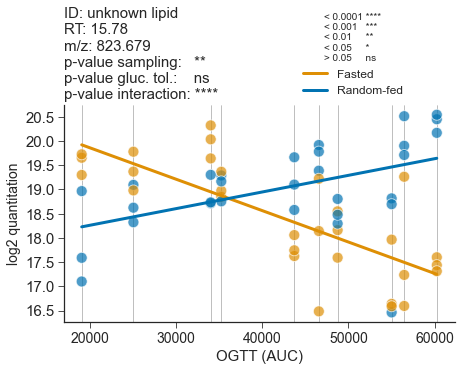

In [147]:
animal_ogtts = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']

def make_fit_plot(feature, folder_path=None, file_type=None, savefig=False):
    fig, ax = plt.subplots(figsize=(7, 4))
#     feature = 'l_649'
    subset = data.loc[[feature], data_cols].T
    subset = subset.join(fg[['bg_type', 'ogtt']])
    sns.scatterplot(
        data=subset, x='ogtt', y=feature,          
        hue='bg_type', palette=colors, 
        s=120, alpha=0.7, legend=False,
        ax=ax)
    intercept, samp_rbg, ogtt, cross = data.loc[feature, data.filter(regex='model_par').columns]
    plt.plot(*get_model_params(feature, df=data)['FBG'], color=colors['FBG'], linewidth=3, label='Fasted')
    plt.plot(*get_model_params(feature, df=data)['RBG'], color=colors['RBG'], linewidth=3, label='Random-fed')
    for animal_ogtt in animal_ogtts:
        plt.axvline(animal_ogtt, c='gray', zorder=-10, linewidth=0.5)

    qvals = data.loc[feature, ['qval_sampling', 'qval_ogtt', 'qval_sampling:ogtt']].to_list()
    _type = data.loc[feature, 'Type']
    unique_id = data.loc[feature, 'unique_id']
    _id = data.loc[feature, 'ID']
    rt = data.loc[feature, 'RT']
    mz = data.loc[feature, 'm/z']
    plt.title(f'ID: {_id} {_type}\nRT: {round(rt, 2)}\nm/z: {round(mz, 4)}'
              f'\np-value sampling:   {parse_pval(qvals[0])}\n'  # round(qvals[0], 4)
              f'p-value gluc. tol.:    {parse_pval(qvals[1])}\n'  # round(qvals[1], 4)
              f'p-value interaction: {parse_pval(qvals[2])}',   # round(qvals[2], 4)
              fontsize=15, ha='left', loc='left')
    plt.yticks(fontsize=15)
    plt.ylabel('log2 quantitation', fontsize=14)
    plt.xlabel('OGTT (AUC)', fontsize=15)
    plt.xticks(fontsize=14)
    legend_title = '< 0.0001 ****\n< 0.001   ***\n< 0.01     **\n< 0.05     *\n> 0.05     ns'
    plt.legend(loc=(0.6, 1.02), title=legend_title, fontsize=12, ncol=1)
    sns.despine()
    if savefig:
        file_name = data.loc[feature, 'Type'] + '_' + str(rt) + '_' + str(mz)
        plt.savefig(f'{folder_path}/{file_name}.{file_type}', dpi=100, bbox_inches='tight', facecolor='white')
        plt.close()
make_fit_plot(feature='l_648', folder_path='../reports/figures/all_metabolite_plots')

In [149]:
for i, feature in enumerate(data.index):
    print(i)
    superclass = data.loc[feature, 'superclass']
    _type = data.loc[feature, 'Type']
    if superclass == 'Unidentified':
        superclass = superclass + '_' + _type
#     else:
#         subpath = ''
#     if superclass == 'Unidentified'
    folder_path = f'../reports/figures/all_metabolite_plots/{superclass}'
    make_fit_plot(feature=feature, folder_path=folder_path, file_type='png', savefig=True)
#     if i == 5:
#         break
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [103]:
y_ogtt = fg.loc[fg['bg_type'] == 'FBG', 'ogtt'].sort_index()
y_ogtt

combined_col_name
1060_10_FBG    48742.5
1060_8_FBG     48742.5
1060_9_FBG     48742.5
1062_10_FBG    43717.5
1062_8_FBG     43717.5
1062_9_FBG     43717.5
1074_10_FBG    35250.0
1074_8_FBG     35250.0
1074_9_FBG     35250.0
1076_10_FBG    60245.0
1076_8_FBG     60245.0
1076_9_FBG     60245.0
1082_10_FBG    56462.5
1082_8_FBG     56462.5
1082_9_FBG     56462.5
1091_10_FBG    19060.0
1091_8_FBG     19060.0
1091_9_FBG     19060.0
1092_10_FBG    34022.5
1092_8_FBG     34022.5
1092_9_FBG     34022.5
1093_10_FBG    25057.5
1093_8_FBG     25057.5
1093_9_FBG     25057.5
1101_10_FBG    55007.5
1101_8_FBG     55007.5
1101_9_FBG     55007.5
1102_10_FBG    46565.0
1102_8_FBG     46565.0
1102_9_FBG     46565.0
Name: ogtt, dtype: float64

In [18]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_slopes(feature, df): 
#     params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = df.loc[feature, 'model_param_Intercept']
    interceptrbg = interceptfbg + df.loc[feature, 'model_param_sampling[T.RBG]']
    ogtt_param = df.loc[feature, 'model_param_ogtt']
    sampling_ogtt_cross_param = df.loc[feature, 'model_param_sampling[T.RBG]:ogtt']
    
    minfbg = interceptfbg + ogtt_param * min_ogtt
    minrbg = interceptrbg + ogtt_param * min_ogtt + sampling_ogtt_cross_param * min_ogtt
    maxfbg = interceptfbg + ogtt_param * max_ogtt
    maxrbg = interceptrbg + ogtt_param * max_ogtt + sampling_ogtt_cross_param * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_332', data)
test

{'RBG': [[19060.0, 60245.0], [39.362305205317945, 90.60244106092115]],
 'FBG': [[19060.0, 60245.0], [37.079582242394736, 79.00802709159697]]}

In [ ]:
# Intercept is the starting point
def calc_line(m, b):
    #  y = mx + b  equation for line
    y1 = m * min_ogtt + b
    y2 = m * max_ogtt + b
    return [min_ogtt, max_ogtt], [y1, y2]